# Image Segmentation Test

### Requirements
- .jpg files for the images in ./images for the input images
- .png files in ./annotations/trimaps with the same name for the segmentation mask

In [41]:
# imports
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.utils import load_img, img_to_array, array_to_img
import pathlib
from keras import layers
import numpy as np
import random

In [10]:
input_dir = pathlib.Path("images/")
target_dir = pathlib.Path("annotations/trimaps/")

input_img_paths = sorted([
    input_dir / fname for fname in os.listdir(input_dir) if fname.endswith(".jpg")
])
target_paths = sorted([target_dir / fname for fname in os.listdir(target_dir) if
                       fname.endswith(".png") and not fname.startswith(".")])

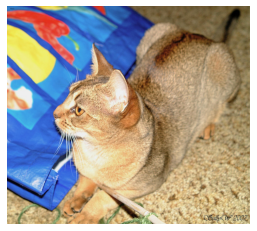

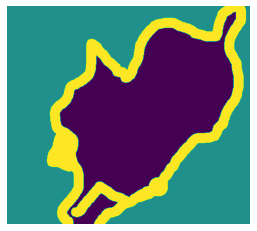

In [20]:
# experimentation with data
plt.axis("off")
plt.imshow(load_img(input_img_paths[9]))
plt.show()

def display_target(target_array):
    normalized_array = (target_array.astype("uint8") - 1) * 127
    plt.axis("off")
    plt.imshow(normalized_array)
img = img_to_array(load_img(target_paths[9], color_mode="grayscale"))
display_target(img)

In [29]:
# load in the data
img_size = (200, 200)
num_img = len(input_img_paths)

random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_paths)

def path_to_input_image(path):
    return img_to_array(load_img(path, target_size=img_size))

def path_to_target(path):
    img = img_to_array(load_img(path, target_size=img_size, color_mode="grayscale"))
    img = img.astype("uint8") - 1
    return img

input_imgs = np.zeros((num_img,) + img_size + (3,), dtype="float32")
targets = np.zeros((num_img,) + img_size + (1,), dtype="uint8")
for i in range(num_img):
    input_imgs[i] = path_to_input_image(input_img_paths[i])
    targets[i] = path_to_target(target_paths[i])

In [32]:
# split into validation and training
num_val_samples = 1000
train_input_imgs = input_imgs[:-num_val_samples]
train_targets = targets[:-num_val_samples]
val_input_imgs = input_imgs[-num_val_samples:]
val_targets = targets[-num_val_samples:]

In [34]:
def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))
    x = layers.Rescaling(1./255)(inputs)

    x = layers.Conv2D(64, 3, strides=2, activation="relu", padding="same")(x)
    x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(128, 3, strides=2, activation="relu", padding="same")(x)
    x = layers.Conv2D(128, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(256, 3, strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2D(256, 3, padding="same", activation="relu")(x)

    x = layers.Conv2DTranspose(256, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(256, 3, activation="relu", padding="same", strides=2)(x)
    x = layers.Conv2DTranspose(128, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(128, 3, activation="relu", padding="same", strides=2)(x)
    x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same", strides=2)(x)

    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    model = keras.Model(inputs, outputs)
    return model

model = get_model(img_size=img_size, num_classes=3)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 200, 200, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 100, 100, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 64)      36928     
                                                                 
 conv2d_2 (Conv2D)           (None, 50, 50, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 50, 50, 128)       147584    
                                                                 
 conv2d_4 (Conv2D)           (None, 25, 25, 256)       295168

In [40]:
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")
callbacks = [keras.callbacks.ModelCheckpoint(filepath="oxford_segmentation.keras", save_best_only=True)]
history = model.fit(train_input_imgs, train_targets.reshape((-1,) + img_size), callbacks=callbacks,
                    epochs=50, batch_size=64, validation_data=(val_input_imgs, val_targets.reshape((-1,) + img_size)))

Epoch 1/50
  2/100 [..............................] - ETA: 19:54 - loss: 1.0597

KeyboardInterrupt: 

In [ ]:
epochs = range(1, 51)
loss = history.history["loss"]
val_loss = history.history["val_loss"]
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

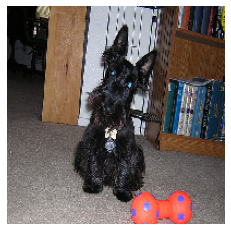

1/1 [==============================] - 0s 308ms/step


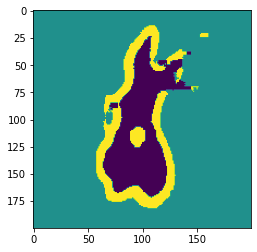

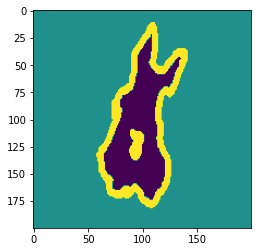

In [69]:
model = keras.models.load_model("oxford_segmentation.keras")

def display_with_mask(ind):
    i = ind
    test_image = val_input_imgs[i].astype("uint8")
    plt.axis("off")
    plt.imshow(test_image)
    plt.show()
    mask = model.predict(np.expand_dims(test_image, 0))
    mask = np.argmax(mask, axis=-1).squeeze(axis=0)
    mask *= 127
    plt.imshow(mask)
    plt.show()
    target_image = val_targets[i].astype("uint8").squeeze(axis=2)
    target_image *= 127
    plt.imshow(target_image)

display_with_mask(15)

